# Trabajo Práctico Número 2 - Procesamiento de Señales, Fundamentos

## DFT - Ejercicio I
Graﬁque las siguientes señales lado a lado con su respectivo espectro en frecuencias:  1) Senoidal. 2) Cuadrada. 3) Triangular 4) Delta en t=0. Indicando en cada caso los siguientes parámetros (si corresponde) : 1) Frecuencia. B) Amplitud. C) Potencia promedio. D) Fs. E) N. 5) Pegue el link a un pdf con los códigos, gráficos y comentarios.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from enum import Enum, auto
from copy import deepcopy as cpy
from dataclasses import dataclass, field

@dataclass
class PsfWaveformSpec:
  fo_hz: float
  fs_hz: float
  samples_n: int
  ph_rad: float = 0
  amp: float = 1

@dataclass
class PsfWaveformData(PsfWaveformSpec):
  power_time: float = 0
  power_freq: float = 0


# Waveform Generators.
def psf_sine(spec: PsfWaveformSpec):
  amp = 0 if spec.amp < 0 else 1 if spec.amp > 1 else spec.amp
  n = np.arange(spec.samples_n) 
  return amp * np.sin((2 * np.pi * spec.fo_hz * n / spec.fs_hz) + spec.ph_rad)

def psf_square(spec: PsfWaveformSpec):
  amp = 0 if spec.amp < 0 else 1 if spec.amp > 1 else spec.amp
  n = np.arange(spec.samples_n) 
  return amp * signal.square(2 * np.pi * spec.fo_hz * n / spec.fs_hz + + spec.ph_rad, .5) 
  
def psf_tri(spec: PsfWaveformSpec):
  amp = 0 if spec.amp < 0 else 1 if spec.amp > 1 else spec.amp
  n = np.arange(spec.samples_n) 
  return amp * signal.sawtooth(2 * np.pi * spec.fo_hz * n / spec.fs_hz + + spec.ph_rad, .5) 

def psf_delta(spec: PsfWaveformSpec):
  amp = 0 if spec.amp < 0 else 1 if spec.amp > 1 else spec.amp
  sn = np.zeros(spec.samples_n) 
  sn[0] = 1.0
  return sn



# Utilities.
def psf_spec_to_time_sec(spec: PsfWaveformSpec):
  return np.arange(spec.samples_n) * 1/spec.fs_hz

def psf_gen_cont_and_disc_wvfm(spec: PsfWaveformSpec, fun=psf_sine):
  spec_cont = cpy(spec)
  spec_cont.fs_hz = spec_cont.fs_hz * 100
  spec_cont.samples_n = spec_cont.samples_n * 100
  return (psf_spec_to_time_sec(spec), fun(spec)), (psf_spec_to_time_sec(spec_cont), fun(spec_cont))  

def easy_fft(x, fs):
    fft = np.abs(np.fft.fftshift(np.fft.fft(x)/len(x)))
    fft_fs = np.fft.fftshift(np.fft.fftfreq(len(x), 1/fs))
    return fft, fft_fs

def get_avg_power_f(X):
  return np.sum(abs(X)**2)

def get_avg_power_t(x):
  return np.sum(x**2) / len(x)


font = {'weight' : 'normal',
        'size'   : 12}

plt.rc('font', **font)

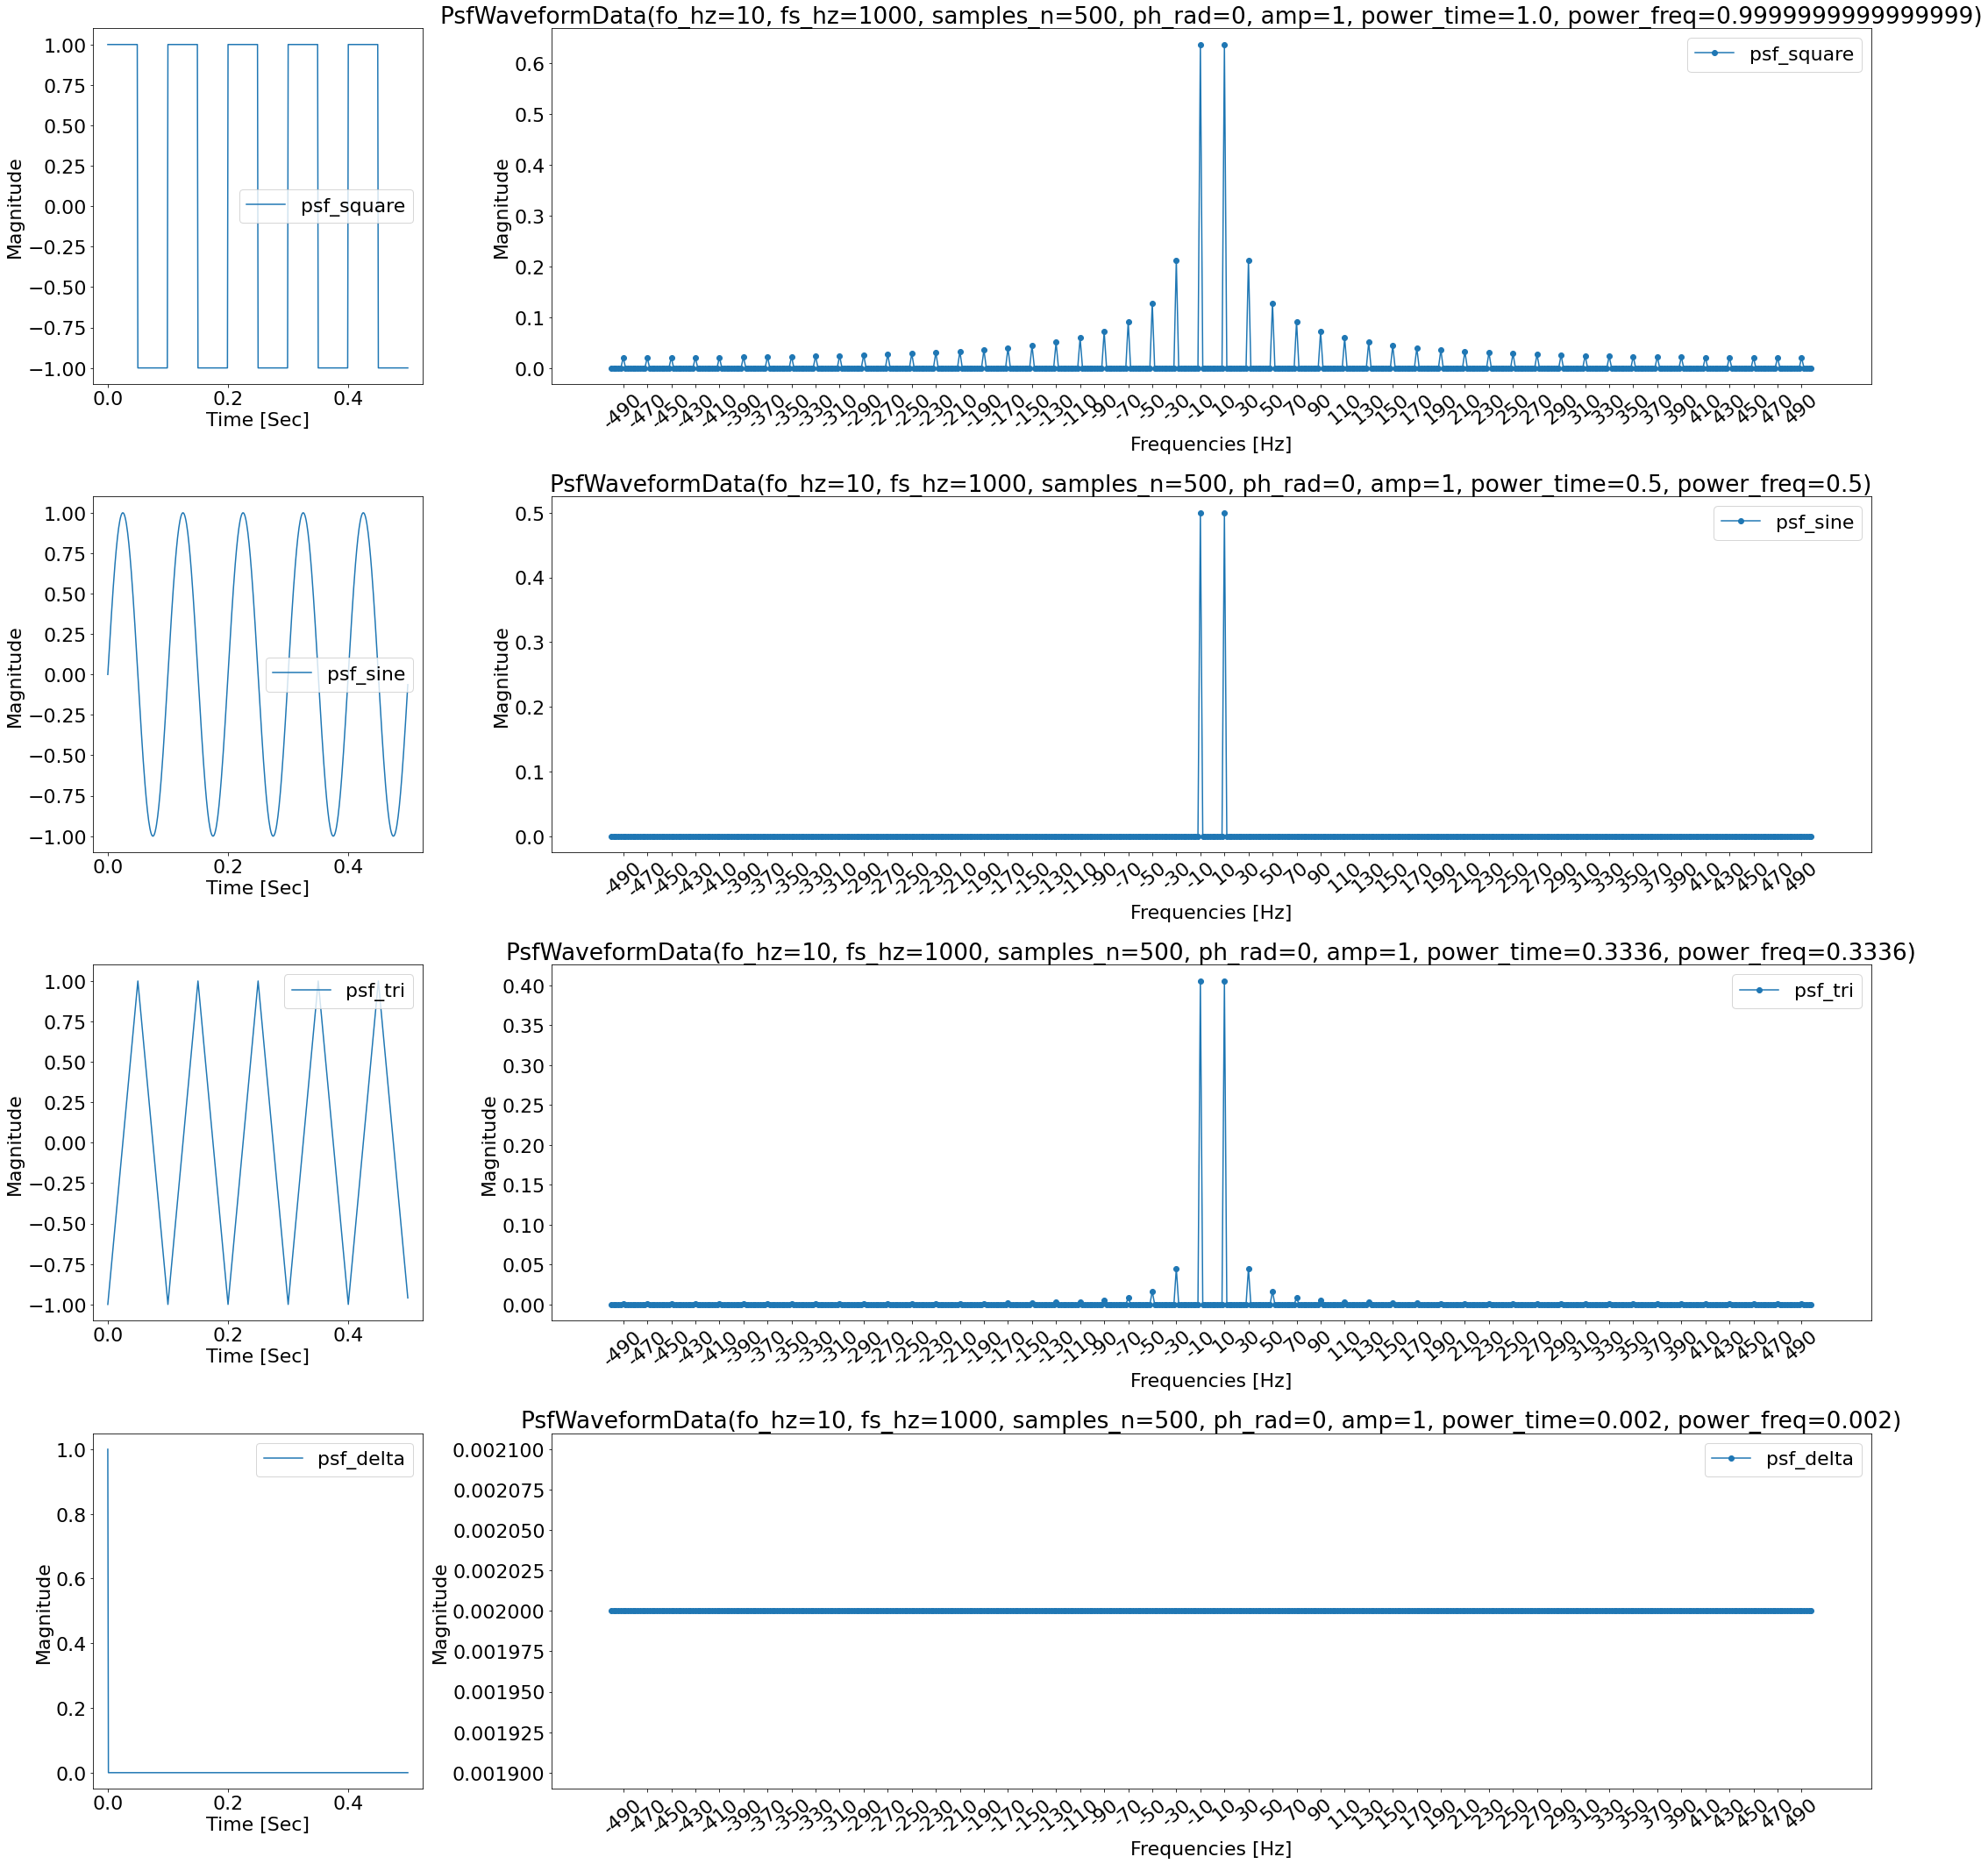

In [8]:
def get_avg_power(spectrum):
  return np.sqrt(np.sum(spectrum**2))



font = {'weight' : 'normal',
        'size'   : 22}

plt.rc('font', **font)

wfm = PsfWaveformSpec(
    fo_hz = 10,
    fs_hz = 1000,
    samples_n = 500,
    ph_rad = 0,
    amp = 1
)

waveforms = (psf_square, psf_sine, psf_tri, psf_delta)

fig, axs = plt.subplots(len(waveforms), 2 , figsize=(30, 30), gridspec_kw={'width_ratios': [1, 4]})


for i, fun in enumerate((psf_square, psf_sine, psf_tri, psf_delta)):
  time = np.arange(0, wfm.samples_n) * 1/wfm.fs_hz
  sig = fun(wfm)
  fft, fft_fs = easy_fft(sig, wfm.fs_hz)
  
  d = PsfWaveformData(power_freq=get_avg_power_f(fft), power_time=get_avg_power_t(sig),  **wfm.__dict__)
  axs[i, 0].plot(time, sig, label=fun.__name__)
  axs[i, 0].legend()
  axs[i, 0].set_xlabel('Time [Sec]')
  axs[i, 0].set_ylabel('Magnitude')
  axs[i, 1].set_title(str(d))
  axs[i, 1].plot(fft_fs, fft, '-o', label=fun.__name__)
  axs[i, 1].legend()
  axs[i, 1].set_xlabel('Frequencies [Hz]')
  axs[i, 1].set_ylabel('Magnitude')
  axs[i, 1].set_xticks(range(-490, 500, 20))
  axs[i, 1].set_xticklabels(range(-490, 500, 20), rotation=40)

plt.tight_layout()
plt.show()


## DFT - Ejercicio I - Comentarios
Se puede observar que:

* El espectro de la señal cuadrada cuenta con contenido armónico múltiplo de la
frecuencia original, pero con armonicos _páres_ nulos. 

* El espectro de la señal triángular es similar a la cuadrada, pero la 
atenucación de cada armónico subsiguiente es aún mayor (cuadrática inversa).

* El espectro de la señal senoidal consiste de únicamente un pico de frecuencia,
con su contraparte en frecuencias negativas.

* El espectro de la delta es constante. Cabe destacar que el valor de dicha 
constante es tal que su *energía* total en el espectro es igual a 1. 
Cobra más sentido hablar de energía en este caso, porque no es una señal 
periódica como las anteriores.

## DFT ejercicio II
Dado el archivo clases/tp2/resolucion_espectral.txt  que contiene 100 valores reales sampleados a Fs=200Hz, indique: 1) Resolución espectral. 2) Espectro en frecuencia de la señal. 3) A simple inspección que frecuencia(s) distingue. 4) Aplique alguna técnica que le permita mejorar la resolución espectral y tome nuevamente el espectro. 5) Indique si ahora los resultados difieren del punto 3 y argumente su respuesta. 6) Pegue el link a un pdf con los códigos, gráficos y comentarios.

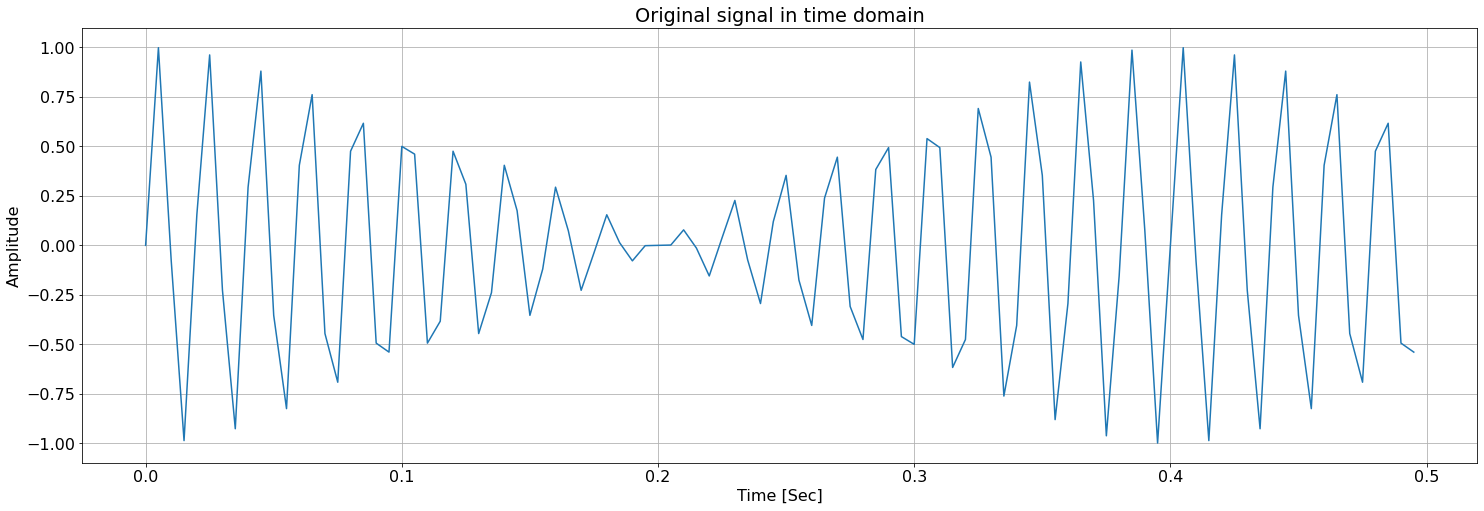

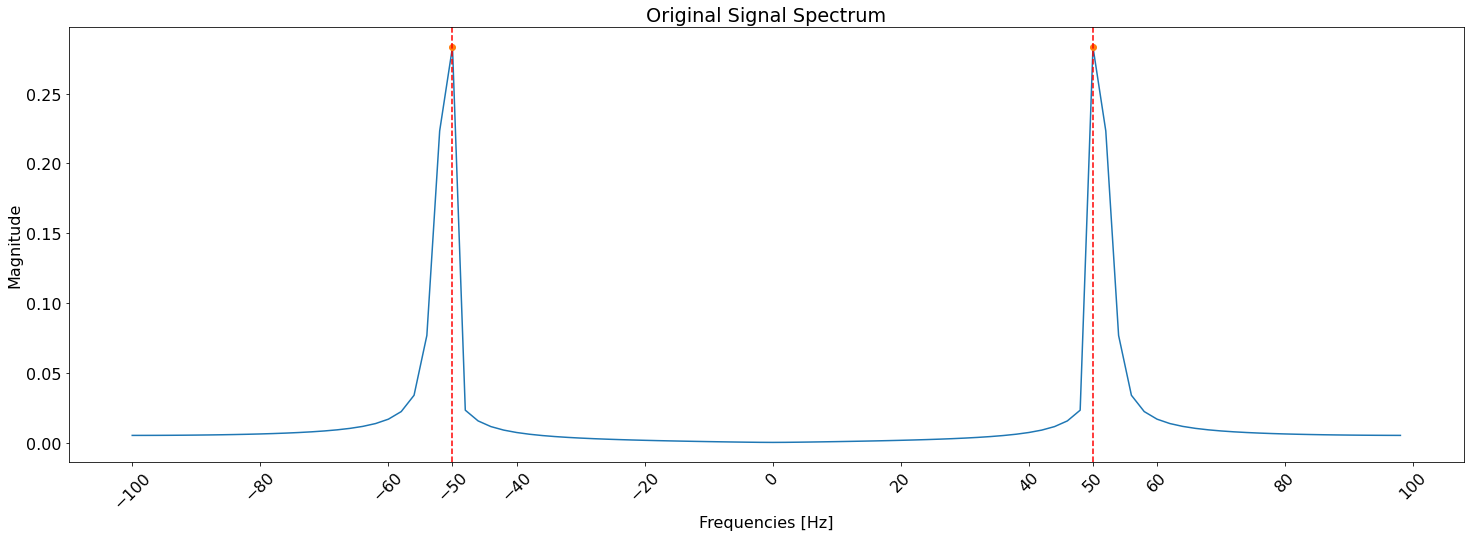

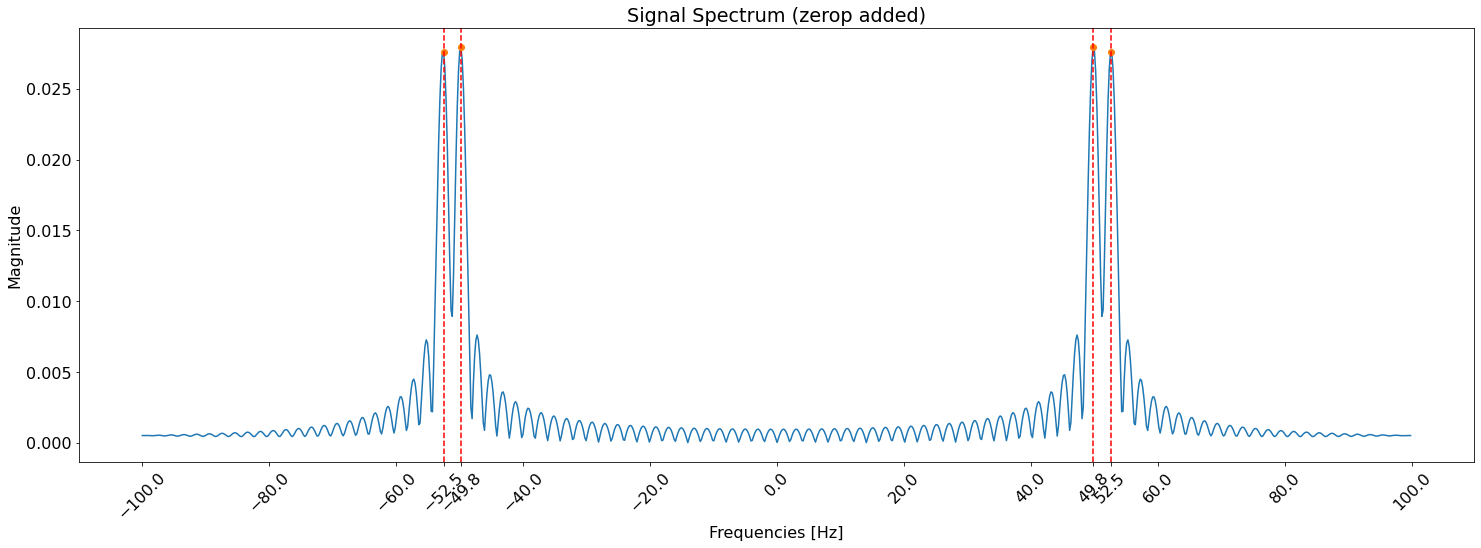

Peaks before padding (Hz): -50.0; 50.0
Peaks after padding (Hz): -52.5390625; -49.8046875; 49.8046875; 52.5390625


In [17]:
import numpy as np
import scipy


font = {'weight' : 'normal',
        'size'   : 16}

plt.rc('font', **font)

# Constants.
FS = 200
PSF_FILE = './data/resolucion_espectral.txt' 
PADDING_SIG_LEN_MULT = 5

# Waveform loading.
with open(PSF_FILE) as f:
    sig = np.array(eval(f.read()))
    time = np.arange(len(sig)) * 1/FS

# Original signal in time domain.
plt.figure(figsize=(25,8))
plt.plot(time, sig)
plt.grid()
plt.ylabel('Amplitude')
plt.xlabel('Time [Sec]')
plt.title('Original signal in time domain')
plt.show()

# Original signal spectrum
## FFT & peak detection.
fft, freqs = easy_fft(sig, FS)
peaks_ind, peaks = scipy.signal.find_peaks(fft, height=0.15)
peaks_fs = [freqs[i] for i in peaks_ind]
peaks_vals = peaks['peak_heights']
# ---
plt.figure(figsize=(25,8))
plt.plot(freqs, fft)
plt.plot(peaks_fs, peaks_vals, 'o')
for f in peaks_fs:
    plt.axvline(x=f, color='r', linestyle='--')
plt.title('Original Signal Spectrum')
plt.xticks(np.concatenate((np.linspace(-100, 100, 11), peaks_fs)), rotation=45)
plt.xlabel('Frequencies [Hz]')
plt.ylabel('Magnitude')
plt.show()


# Signal padded
## FFT & peak detection.
sig_padded = np.concatenate((sig, np.zeros(924)))
fft, freqs = easy_fft(sig_padded, FS)
peaks_ind, peaks = scipy.signal.find_peaks(fft, height=0.02)
peaks_pd_fs = [freqs[i] for i in peaks_ind]
peaks_vals = peaks['peak_heights']
plt.figure(figsize=(25,8))
plt.plot(freqs, fft)
plt.plot(peaks_pd_fs, peaks_vals, 'o')
for f in peaks_pd_fs:
    plt.axvline(x=f, color='r', linestyle='--')
plt.xticks(np.concatenate((np.linspace(-100, 100, 11), peaks_pd_fs)), rotation=45)
plt.xlabel('Frequencies [Hz]')
plt.ylabel('Magnitude')
plt.title('Signal Spectrum (zerop added)')
plt.show()

print(f'Peaks before padding (Hz): ' + '; '.join(map(str, peaks_fs)))
print(f'Peaks after padding (Hz): ' + '; '.join(map(str, peaks_pd_fs)))



## DFT - Ejercicio II - Comentarios
Puede observarse que con la resolución espectral resultante de utilizar
únicamente el número de muestras de la señal original, se pueden distinguir
solo dos picos en +-50 Hz. A priori la asimetría en la envolvente de los picos
permite sospechar que no es un tono puro, pero resulta imposible comprender
exactamente cómo está conformada la señal.

Luego de aplicar la técnica de `Zero Padding` para aumentar la resolución en
frecuencia (a costas de perder SNR) se pueden distinguir claramente dos picos
de frecuencias en 48.9 y 52.5 (con su contrapartida negativa). Esto permite
apreciar de mejor manera que la señal original se trata posiblemente de una
suma de dos tonos de estas frecuencias, y no simplemente un tono o señal de
50Hz.

## IDFT - Ejercicio
En el archivo clases/tp2/ﬀt_hjs.npy se almacenaron los valores de un espectro en frecuencia correspondientes a una señal desconocida. Indique: 1) Puede estimar que representa esta señal? (tip: grafique en 2d la idft) 2) Hasta que punto podría limitar el ancho de banda del espectro dado en el archivo y que aun se logre interpretar la señal? 3) Pegue el link a un pdf con los códigos y los gráficos utilizados.

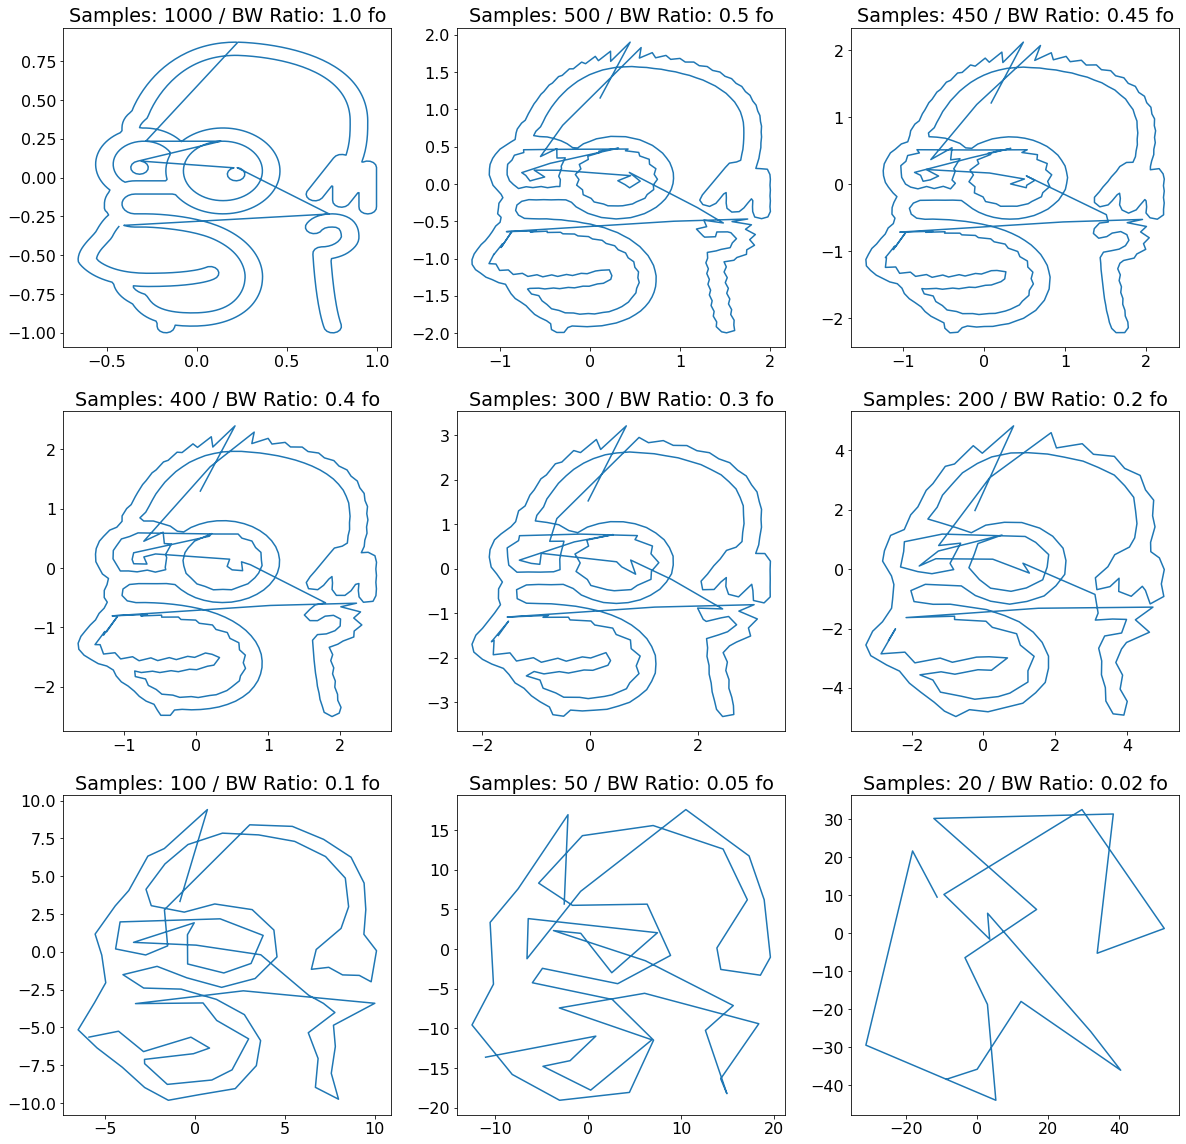

In [18]:
import numpy as np
sig_spectrum = np.load('./data/fft_hjs.npy')

def ifft_2d(x):
    sig = np.fft.ifft(x)
    return (np.imag(sig), np.real(sig))

def spectrum_truncate(x, n):
    return np.concatenate((x[:n], x[len(x)-n:]))
    

test_points =(500, 250, 225, 200, 150, 100, 50, 25, 10)
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(20, 20))
for i in range(3):
    for j in range(3):
        x, y = ifft_2d(spectrum_truncate(sig_spectrum, test_points[3*i + j]))
        axs[i, j].plot(x, y)
        axs[i, j].set_title(f'Samples: {2 * test_points[3*i + j]} / BW Ratio: {test_points[3*i + j] / 500} fo')
plt.show()

## IDFT - Ejercicio - Comentarios
Puede observarse como el Homero Simpson modelado por el espectro de la señal
original se va deformando a medida que se reducen las muestras. Por inspección,
tomando únicamente 200 muestras de las 1000 originales sería suficiente para
reconocer a Homero (y quizás con 100 también).

## CIAA - Ejercicio
Dado el segmento de audio almacenado en el archivo clases/tp2/chapu_noise.npy con Fs=8000, mono de 16b y contaminado con ruido de alta frecuencia: 

1) Diseñe un ﬁltro que mitigue el efecto del ruido y permita percibir mejor la señal de interés 

2) Filtre con la CIAA utilizando alguna de las técnicas vistas 

3) Graﬁque el espectro antes y después del ﬁltro. 

4) Reproduzca el audio antes y después del filtro 

5) Pegue el link a un .zip comentando los resultados y los criterios utilizados, la plantilla del filtro con capturas de la herramienta de diseño y un video mostrando la CIAA/HW en acción y la reproducción de audio antes y después del filtrado.



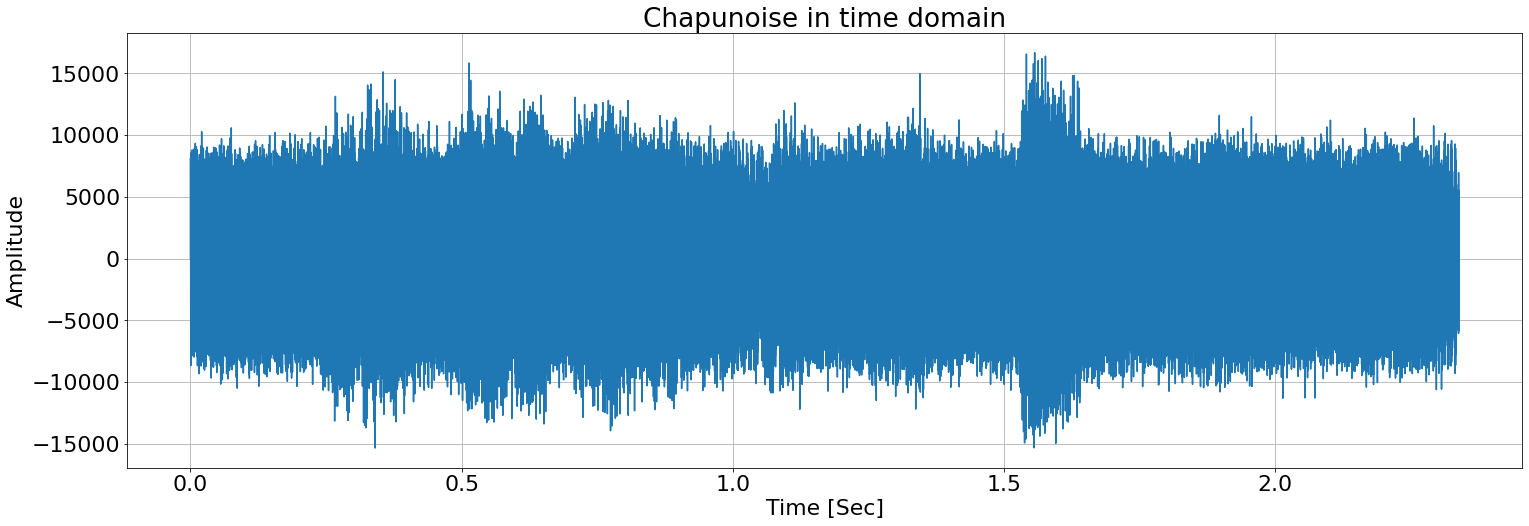

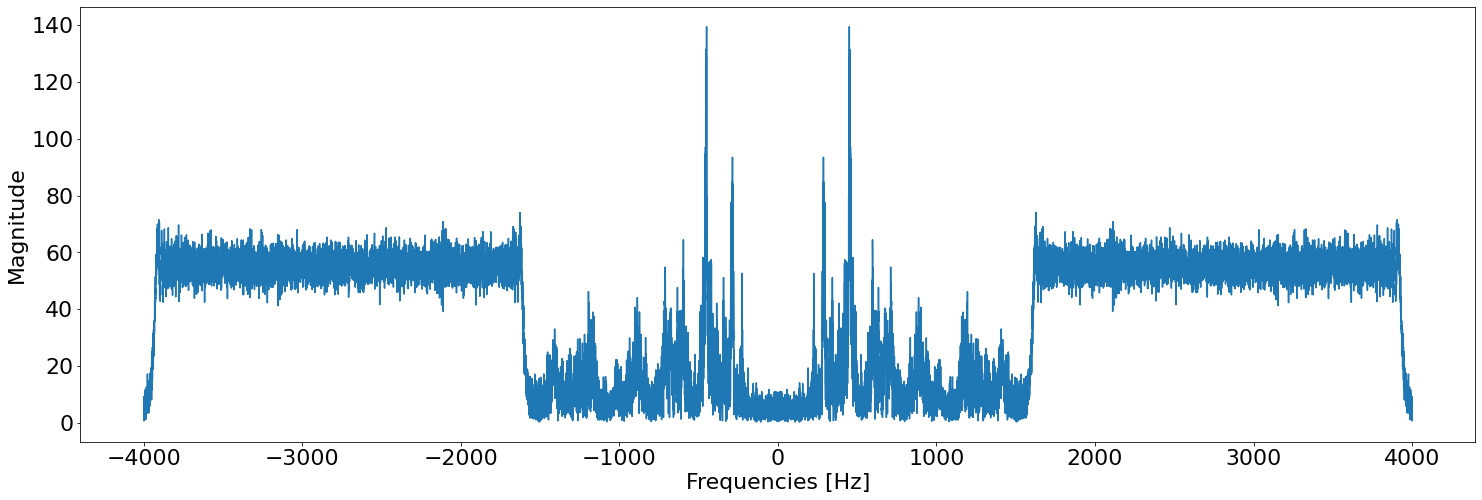

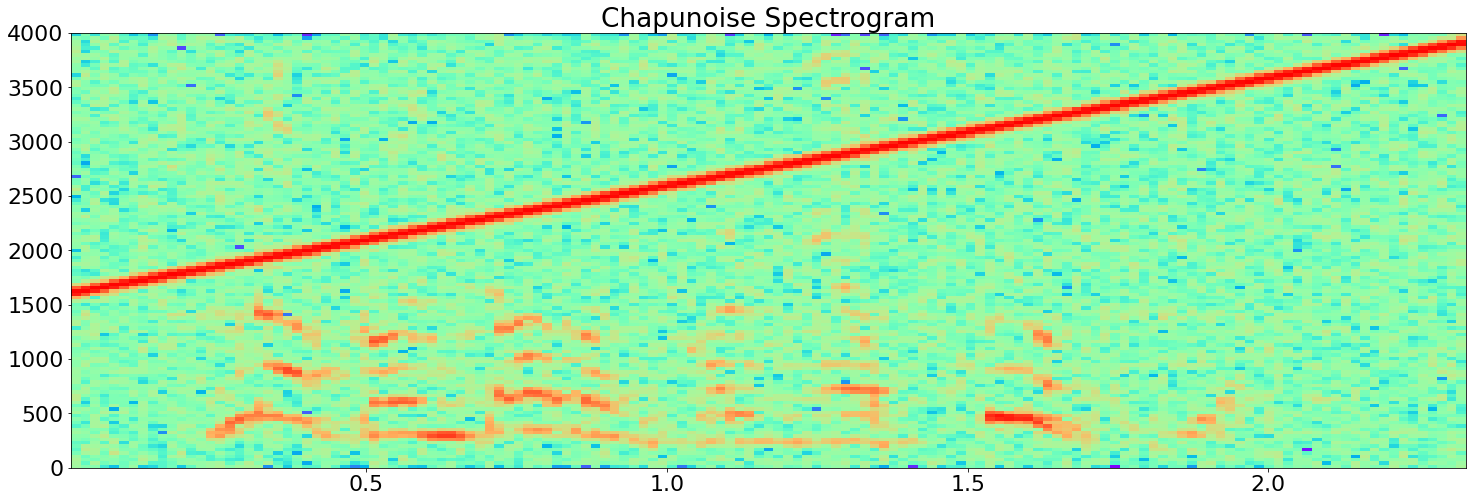

In [83]:
import numpy as np
import matplotlib.pyplot as plt

FS_HZ = 8_000
chapunoise = np.load('./data/chapu_noise.npy')
time = np.arange(len(chapunoise)) * 1 / FS_HZ

plt.figure(figsize=(25,8))
plt.plot(time, chapunoise)
plt.grid()
plt.ylabel('Amplitude')
plt.xlabel('Time [Sec]')
plt.title('Chapunoise in time domain')
plt.show()

fft, fft_fs = easy_fft(chapunoise, FS_HZ)
plt.figure(figsize=(25,8))
plt.xlabel('Frequencies [Hz]')
plt.ylabel('Magnitude')
plt.plot(fft_fs, fft)
plt.show()

plt.figure(figsize=(25,8))
plt.title('Chapunoise Spectrogram')
plt.specgram(chapunoise, Fs=FS_HZ, cmap="rainbow")
plt.xlabel('Time [Sec]')
plt.ylabel('Frequency [Hz]')
plt.show()

## Ejercicio CIAA - Comentarios - Análisis de Señal
Luego de analizar la señal, puede observarse claramente en el espectrograma
una señal del tipo "chirp" (o sweep de frecuencia) a la par de la señal de 
interés. Se empleará un filtro para eliminar el sweep por completo, a sabiendas
de que se degradará levemente la señal de interés (ya que algunos componentes
de frecuencia - armónicos de las principales - se encuentran en la banda a 
atenuar).

### Plantilla del filtro
![filtro](./images/signals/chapunoise_filter.png)

Si bien el filtro no cae abruptamente y es posible (con mucha atención) 
percibir auditivamente el principio de la chirp, se ha optado por (1) no 
decrementarla frecuencia de corte para no perder calidad en la señal de voz y
(2) no utilizar mayor cantidad de muestras para agilizar el procesamiento en 
el MCU posteriormente.

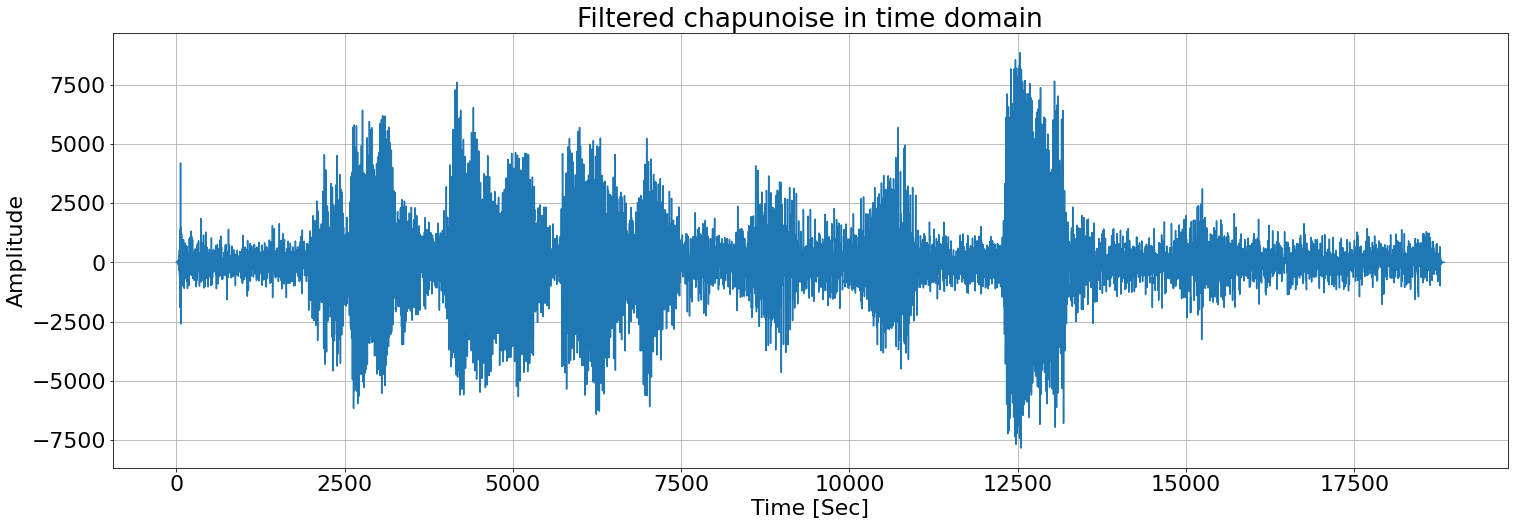

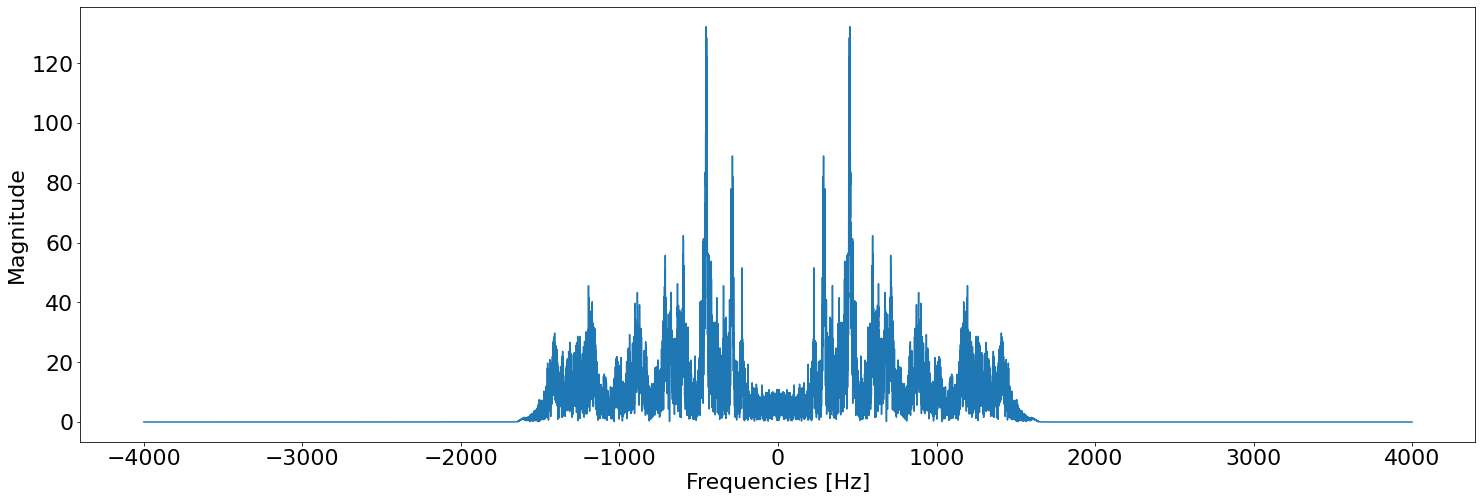

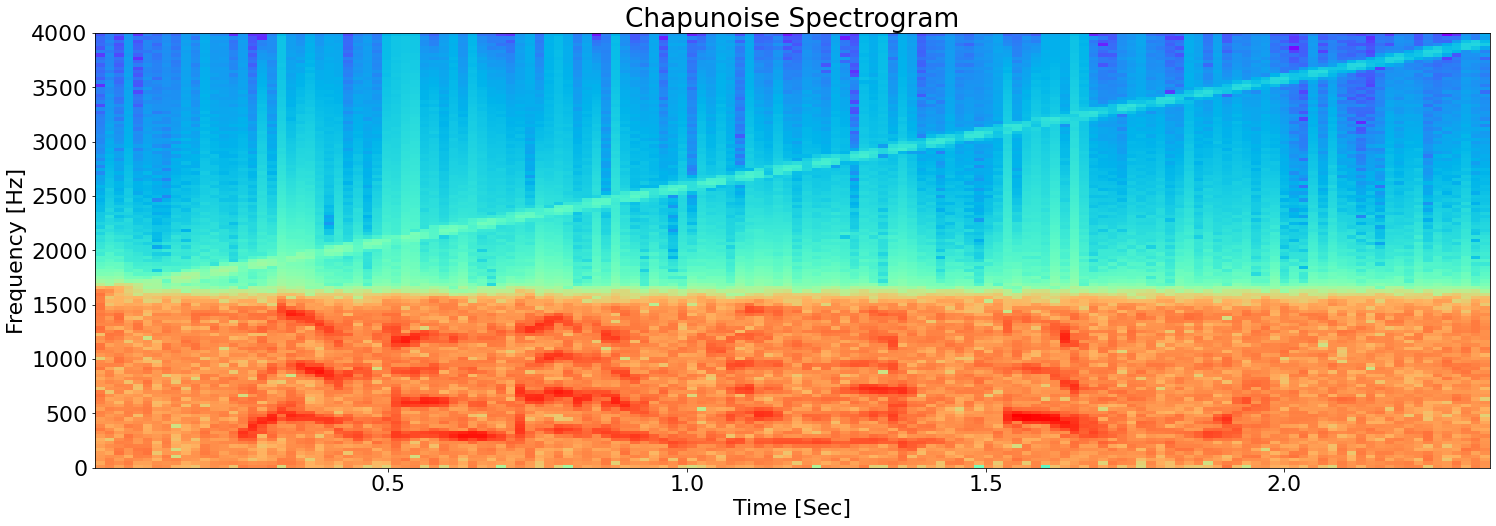

In [85]:
chapu_filter = np.array(np.load('./data/chapu_filter.npy')[0]).astype(float) 
filtered = np.convolve(chapu_filter, chapunoise)

plt.figure(figsize=(25,8))
plt.plot(filtered)
plt.grid()
plt.ylabel('Amplitude')
plt.xlabel('Time [Sec]')
plt.title('Filtered chapunoise in time domain')
plt.show()

fft, fft_fs = easy_fft(filtered, FS_HZ)
plt.figure(figsize=(25,8))
plt.xlabel('Frequencies [Hz]')
plt.ylabel('Magnitude')
plt.plot(fft_fs, fft)
plt.show()


plt.figure(figsize=(25,8))
plt.title('Chapunoise Spectrogram')
plt.specgram(filtered, Fs=FS_HZ, cmap="rainbow")
plt.xlabel('Time [Sec]')
plt.ylabel('Frequency [Hz]')
plt.show()

## Ejercicio CIAA - Comentarios - Post filtrado Python
Se observa tanto en el gráfico de frecuecnia como en el esprectrograma que 
la banda de frecuencias indeseadas ha sido removida con éxito.

## Ejercicio CIAA - Código C
```c
#include "sapi.h"
#include "arm_math.h"
#include "arm_const_structs.h"
#include "fir.h" 

#define BITS    10   // cantidad de bits usado para cuantizar

int16_t offset = 512;
int16_t zero = 0;

struct header_struct {
   char     pre[8];
   uint32_t id;
   uint16_t N;
   uint16_t fs ;
   uint16_t hLength ;
   char     pos[4];
} __attribute__ ((packed));

struct header_struct header={"*header*",0,128,8000,h_LENGTH,"end*"};

int main ( void ) {
   uint16_t sample = 0;
   int16_t adc   [ header.N            ];
   int16_t y     [ h_LENGTH+header.N-1 ];

   boardConfig();
   uartConfig(UART_USB, 460800);
   adcConfig (ADC_ENABLE);
   dacConfig(DAC_ENABLE);
   cyclesCounterInit (EDU_CIAA_NXP_CLOCK_SPEED);

   for(;;) {
      cyclesCounterReset();
      adc[sample] = (((int16_t )adcRead(CH1)-512)>>(10-BITS))<<(6+10-BITS);
      dacWrite(DAC, y[sample]); // will be 128 samples delayed from input.
      if (++sample==header.N ) {
         gpioToggle ( LEDR );
         sample = 0;
         arm_conv_q15       ( adc,header.N,h,h_LENGTH,y);
         header.id++;
         uartWriteByteArray ( UART_USB ,(uint8_t*)&header ,sizeof(struct header_struct ));
         for (int i=0;i<(header.N+h_LENGTH-1 );i++) {
            uartWriteByteArray ( UART_USB ,(uint8_t* )(i<header.N?&adc[i]:&offset ),sizeof(adc[0]));
            uartWriteByteArray ( UART_USB ,(uint8_t* )(i<h_LENGTH?&h  [i]:&zero   ),sizeof(h[0])  );
            uartWriteByteArray ( UART_USB ,(uint8_t* )(           &y  [i]         ),sizeof(y[0])  );
         }
         adcRead(CH1);
      }
      gpioToggle(LED1);
      while(cyclesCounterRead()< EDU_CIAA_NXP_CLOCK_SPEED/header.fs)
         ;
   }
}
```

El archivo `fir.h` puede obtenerse del repositorio Github (https://github.com/lorsi96/Signal-Processing-Fundaments---MSE07/blob/master/ciaa_chapunoise/src/fir.h).
No se incluye aquí para evitar prolongar el documento con contenido que no 
aporta valor.

In [33]:
# Reproducción de audio antes/después.
from IPython.display import display, Audio
from ipywidgets import interactive

display(Audio(data=chapunoise, rate = 8000, autoplay=False))
display(Audio(data=filtered, rate = 8000, autoplay=False))

## Videos Demostrativos
[Captura de señales CIAA](./images/hardware/CIAA_Filter.gif)

[Hardware + CIAA Funcionando](https://drive.google.com/file/d/1KMyS2J_aEVPtWXeZJMkIJLJTIG-PdBv0/view?usp=sharing)
